In [1]:
%cd -q ../..

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from dotenv import load_dotenv
from matplotlib import pyplot as plt

from scotus_metalang.diachronic_analysis import authors, prediction_graphing
from scotus_metalang.diachronic_analysis.graphing import save_and_show

load_dotenv()
data_path = os.environ["SCOTUS_METALANG_DATA_PATH"]
model_name = "binary_token_model_bert_large_8_epochs"

plt.ioff()

### Read prediction data


In [3]:
with open(f"{data_path}/cap/statutory_interpretation_opinions.txt", "r") as f:
    stat_int_file_paths = f.read().splitlines()


In [4]:
op_paths_to_pred_paths = {}
stat_int_op_path_to_pred_paths = {}
non_stat_int_op_path_to_pred_paths = {}
for author in authors.ORDERED_JUSTICES:
    for opinion_path in Path(f"{data_path}/cap/known_authors/{author}").glob("*.json"):
        filename = opinion_path.stem + ".txt"
        prediction_path = Path(f"{data_path}/predictions", model_name, author, filename)
        if f"{author}/{opinion_path.name}" in stat_int_file_paths:
            stat_int_op_path_to_pred_paths[opinion_path] = prediction_path
        else:
            non_stat_int_op_path_to_pred_paths[opinion_path] = prediction_path
        op_paths_to_pred_paths[opinion_path] = prediction_path
df = prediction_graphing.load_predictions(op_paths_to_pred_paths)
stat_df = prediction_graphing.load_predictions(stat_int_op_path_to_pred_paths)
non_stat_df = prediction_graphing.load_predictions(non_stat_int_op_path_to_pred_paths)
df.head()

,docket_number,author,opinion_type,term,tokens,ft,mc,dq,les
0,86-1088,brennan,concurrence,1988,37,0,0,0,3
1,86-39,brennan,majority,1986,10770,27,113,1993,2811
2,88-515,brennan,concurring-in-part-and-dissenting-in-part,1988,849,3,10,155,243
3,87-548,brennan,dissent,1988,4067,17,11,570,546
4,88-2031,brennan,dissent,1989,11876,27,40,2671,2811


In [5]:
categories = ["ft", "mc", "dq", "les"]

In [6]:
si_df = stat_df
nsi_df = non_stat_df

In [7]:
terms = list(range(1986, 2019))
si_vals = [len(si_df[si_df["term"] == str(t)]) for t in terms]
nsi_vals = [len(nsi_df[nsi_df["term"] == str(t)]) for t in terms]
totals = [s + n for n, s in zip(si_vals, nsi_vals)]
si_ratios = [s/t for s, t in zip(si_vals, totals)]
nsi_ratios = [(1 - s) for s in si_ratios]

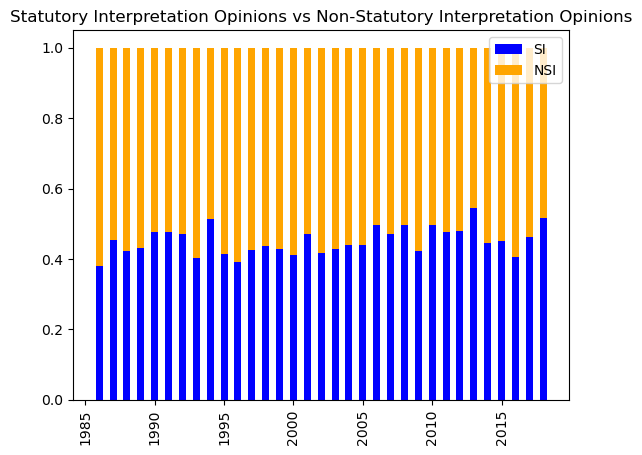

In [8]:
fig = prediction_graphing.plot_si_vs_nsi_ops(stat_df, non_stat_df)
save_and_show(fig, "stat_vs_non_stat", "predictions", show=True)

In [9]:
len(stat_df)

2898

In [10]:
len(non_stat_df)

3586

In [11]:
fig = prediction_graphing.plot_opinion_length_per_term(stat_df)
save_and_show(fig, "opinion_length_by_term", prefix="predictions", show=False)

In [12]:
for category in categories:
    fig = prediction_graphing.plot_frequency_by_author(stat_df, category)
    save_and_show(fig, f"frequency_by_author_{category}", prefix="predictions", show=False)

In [13]:
for category in categories:
    fig = prediction_graphing.plot_frequency_by_term(df, category)
    save_and_show(fig, f"frequency_by_term_{category}", prefix="predictions", show=False)

In [14]:
ci = True
for category in categories:
    if ci:
        filename = f"rate_of_{category}_trend_ci"
    else:
        filename = f"rate_of_{category}_trend"
    fig = prediction_graphing.plot_frequency_line_with_trend(df, category, ci=ci)

    save_and_show(fig, filename, prefix="predictions", show=False)

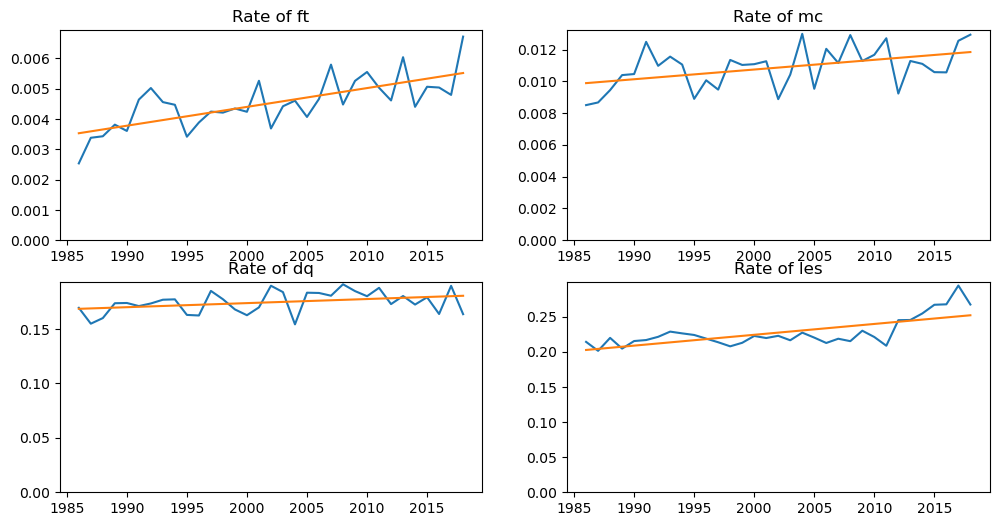

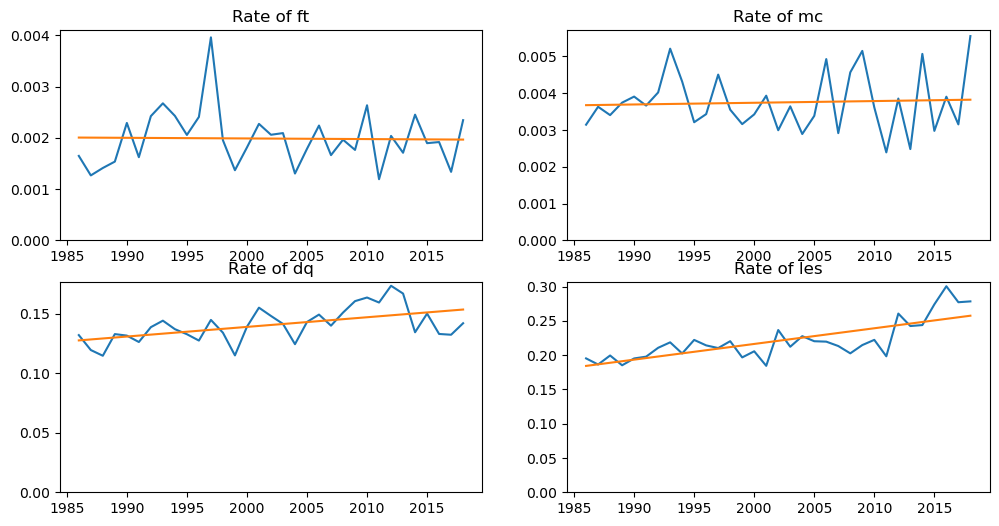

In [15]:
fig = prediction_graphing.plot_frequency_line_all_cats(stat_df)
save_and_show(fig, "stat_line_graphs_with_trends", prefix="predictions", show=True)
fig = prediction_graphing.plot_frequency_line_all_cats(non_stat_df)
save_and_show(fig, "nonstat_line_graphs_with_trends", prefix="predictions", show=True)

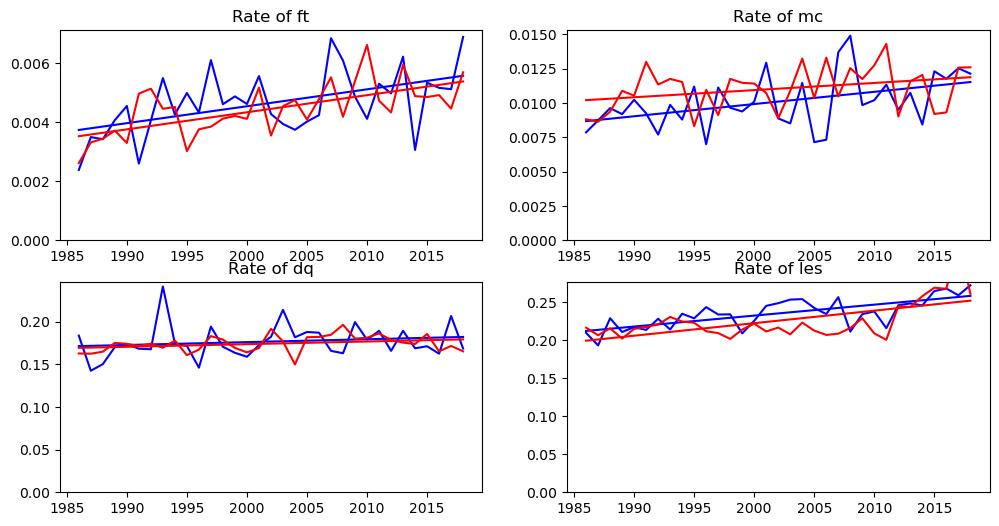

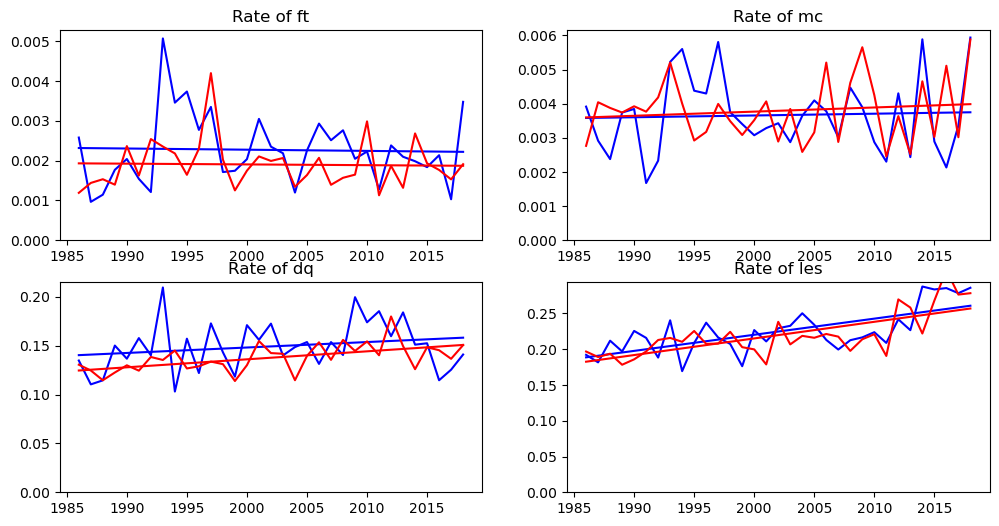

In [16]:
fig = prediction_graphing.plot_frequency_line_all_cats_ideology(stat_df)
save_and_show(fig, "stat_line_graphs_with_trends_by_party", prefix="predictions", show=True)
fig = prediction_graphing.plot_frequency_line_all_cats_ideology(non_stat_df)
save_and_show(fig, "nonstat_line_graphs_with_trends_by_party", prefix="predictions", show=True)

In [17]:
fig = prediction_graphing.plot_frequency_line_all_cats_ideology(df)
save_and_show(fig, "line_graphs_with_trends_by_party", prefix="predictions", show=False)

In [18]:
fig = prediction_graphing.plot_frequency_line_all_cats(df)
save_and_show(fig, "line_graphs_with_trends", prefix="predictions")

fig = prediction_graphing.plot_frequency_line_all_cats(df, ci=True)
save_and_show(fig, "line_graphs_with_trends_ci", prefix="predictions")

In [19]:
# Frequencies by opinion type
opinion_types = ["concurrence", "majority","concurring-in-part-and-dissenting-in-part", "dissent"]
for op_type in opinion_types:
    sample = stat_df[stat_df["opinion_type"] == op_type]
    fig = prediction_graphing.plot_frequency_line_all_cats(sample)
    save_and_show(fig, f"frequency_in_{op_type}", prefix="predictions", show=False)

In [20]:
# Frequencies by justice ideology
for ideology in ["liberal", "conservative"]:
    authors_of_interest = [author for author in authors.JUSTICE_TO_IDEOLOGY
                            if authors.JUSTICE_TO_IDEOLOGY[author] == ideology]
    df_sample = df[df["author"].isin(authors_of_interest)]
    fig = prediction_graphing.plot_frequency_line_all_cats(df_sample)
    save_and_show(fig, f"frequencies_{ideology}", "predictions", show=False)

TODO: get sets of predicted focal terms by year

Thoughts on line graphs and ci intervals:

Orange is term average of opinion-level category rates (but these rates themselves are predictions).
Light blue/purple is 95% confidence interval.
Blue is least squares trendline.

This is measurement issue (measurement uncertainty and sampling uncertainty)

Don't have to diagnose/solve the potential "trend is artifact of predicting on earlier data than training data" issue

###  Resources

- Trendline: https://www.statology.org/matplotlib-trendline/ (adapted to new numpy.polynomial)
- Confidence interval: https://www.pythoncharts.com/python/line-chart-with-confidence-interval/#matplotlib